<a href="https://colab.research.google.com/github/Arta-DS/DS/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

Генерация 50000 последовательностей длиной 20...

--- Начало обучения модели: RNN ---
Эпоха [2/10], Потеря: 2.0193
Эпоха [4/10], Потеря: 1.9170
Эпоха [6/10], Потеря: 1.8661
Эпоха [8/10], Потеря: 1.6273
Эпоха [10/10], Потеря: 1.0523
--- Обучение RNN завершено за 38.99 секунд ---

--- Начало обучения модели: LSTM ---
Эпоха [2/10], Потеря: 0.7017
Эпоха [4/10], Потеря: 0.0843
Эпоха [6/10], Потеря: 0.0188
Эпоха [8/10], Потеря: 0.0084
Эпоха [10/10], Потеря: 0.0050
--- Обучение LSTM завершено за 55.58 секунд ---

--- Начало обучения модели: GRU ---
Эпоха [2/10], Потеря: 0.8382
Эпоха [4/10], Потеря: 0.0632
Эпоха [6/10], Потеря: 0.0216
Эпоха [8/10], Потеря: 0.0102
Эпоха [10/10], Потеря: 0.0056
--- Обучение GRU завершено за 65.53 секунд ---

--- Оценка на тестовой последовательности ---
Вход (X):      [3, 1, 5, 8, 2, 9, 0, 4, 6, 7, 1, 5, 8, 2, 9, 0, 4, 6, 7, 1]
Ожидание (Y):  [3, 4, 8, 1, 5, 2, 3, 7, 9, 0, 4, 8, 1, 5, 2, 3, 7, 9, 0, 4]
Предсказание RNN: [3, 4, 0, 3, 5, 7, 8, 7, 9, 5, 9, 8, 3, 5,

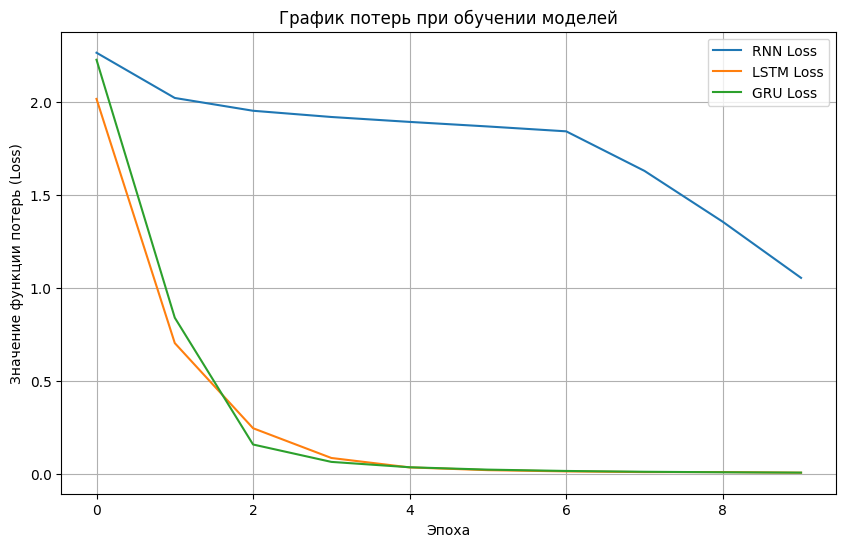

In [2]:
#  1. Конфигурация и генерация данных

# Гиперпараметры
INPUT_SIZE = 10      # Количество уникальных цифр (0-9)
HIDDEN_SIZE = 32     # Размер скрытого состояния RNN
OUTPUT_SIZE = 10     # Количество возможных выходов (0-9)
NUM_EPOCHS = 10      # Количество эпох обучения
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_SAMPLES = 50000  # Общее количество сгенерированных последовательностей
SEQ_LENGTH = 20      # Длина каждой последовательности

def generate_data(num_samples, seq_len):
    """
    Генерирует данные согласно правилу:
    y[0] = x[0]
    y[i] = (x[i] + x[0]) % 10
    """
    # Генерируем случайные входные последовательности X
    X = torch.randint(0, INPUT_SIZE, (num_samples, seq_len))

    # Создаем пустой тензор для выходных данных Y
    Y = torch.zeros_like(X)

    # Первое правило: y[0] = x[0]
    Y[:, 0] = X[:, 0]

    # Второе правило для остальных элементов
    # X[:, 0:1] создает вектор-столбец для правильного "широковещания" (broadcasting)
    Y[:, 1:] = (X[:, 1:] + X[:, 0:1]) % 10

    return X, Y

print(f"Генерация {NUM_SAMPLES} последовательностей длиной {SEQ_LENGTH}...")
X_train, y_train = generate_data(NUM_SAMPLES, SEQ_LENGTH)

# Создаем TensorDataset и DataLoader для удобной подачи данных в модель
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#  2. Определение модели

class SequenceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='lstm', num_layers=1):
        super(SequenceModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        # Слой для преобразования цифр в векторы
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Выбор типа RNN слоя
        if rnn_type.lower() == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Выберите 'rnn', 'lstm' или 'gru'")

        # Полносвязный слой для предсказания следующей цифры
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x) # shape: (batch_size, seq_length, hidden_size)

        # Пропускаем через RNN слой
        # out shape: (batch_size, seq_length, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size)
        out, _ = self.rnn(embedded)

        # Пропускаем выход RNN через полносвязный слой
        out = self.fc(out) # shape: (batch_size, seq_length, output_size)

        return out

#  3. Функции для обучения и предсказания

def train_model(model, train_loader, criterion, optimizer, epochs, model_name):
    """Функция для обучения модели"""
    print(f"\n--- Начало обучения модели: {model_name} ---")
    start_time = time.time()
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)

            # Вычисление потерь
            # CrossEntropyLoss ожидает на входе (N, C), а на выходе (N)
            # Наш outputs имеет форму (batch, seq_len, 10), а targets (batch, seq_len)
            # Поэтому мы "выпрямляем" их
            loss = criterion(outputs.view(-1, OUTPUT_SIZE), targets.view(-1))

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        if (epoch + 1) % 2 == 0:
            print(f'Эпоха [{epoch+1}/{epochs}], Потеря: {avg_loss:.4f}')

    end_time = time.time()
    print(f"--- Обучение {model_name} завершено за {end_time - start_time:.2f} секунд ---")
    return losses

def predict(model, x_sequence):
    """Делает предсказание для одной последовательности"""
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():
        # Добавляем измерение батча (batch_size=1)
        input_tensor = torch.tensor(x_sequence, dtype=torch.long).unsqueeze(0)

        # Получаем выход модели
        output = model(input_tensor)

        # Находим индекс с максимальной вероятностью для каждого шага
        predicted_indices = torch.argmax(output, dim=-1)

        # Убираем измерение батча и возвращаем как список
        return predicted_indices.squeeze(0).tolist()

#  4. Обучение моделей

# Инициализация моделей, оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()

# Модель 1: RNN
model_rnn = SequenceModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, rnn_type='rnn')
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)
losses_rnn = train_model(model_rnn, train_loader, criterion, optimizer_rnn, NUM_EPOCHS, "RNN")

# Модель 2: LSTM
model_lstm = SequenceModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, rnn_type='lstm')
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
losses_lstm = train_model(model_lstm, train_loader, criterion, optimizer_lstm, NUM_EPOCHS, "LSTM")

# Модель 3: GRU
model_gru = SequenceModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, rnn_type='gru')
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)
losses_gru = train_model(model_gru, train_loader, criterion, optimizer_gru, NUM_EPOCHS, "GRU")

#  5. Оценка результатов и визуализация

# Пример для тестирования
test_sequence = [3, 1, 5, 8, 2, 9, 0, 4, 6, 7, 1, 5, 8, 2, 9, 0, 4, 6, 7, 1]
# Ожидаемый результат:
# y[0] = 3
# y[i] = (x[i] + 3) % 10
expected_output = [3, 4, 8, 1, 5, 2, 3, 7, 9, 0, 4, 8, 1, 5, 2, 3, 7, 9, 0, 4]

print("\n--- Оценка на тестовой последовательности ---")
print(f"Вход (X):      {test_sequence}")
print(f"Ожидание (Y):  {expected_output}")

# Предсказания RNN
prediction_rnn = predict(model_rnn, test_sequence)
print(f"Предсказание RNN: {prediction_rnn}")
print(f"Точность RNN: {np.mean(np.array(prediction_rnn) == np.array(expected_output)):.2%}")

# Предсказания LSTM
prediction_lstm = predict(model_lstm, test_sequence)
print(f"Предсказание LSTM: {prediction_lstm}")
print(f"Точность LSTM: {np.mean(np.array(prediction_lstm) == np.array(expected_output)):.2%}")

# Предсказания GRU
prediction_gru = predict(model_gru, test_sequence)
print(f"Предсказание GRU: {prediction_gru}")
print(f"Точность GRU: {np.mean(np.array(prediction_gru) == np.array(expected_output)):.2%}")


# Визуализация потерь во время обучения
plt.figure(figsize=(10, 6))
plt.plot(losses_rnn, label='RNN Loss')
plt.plot(losses_lstm, label='LSTM Loss')
plt.plot(losses_gru, label='GRU Loss')
plt.title('График потерь при обучении моделей')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь (Loss)')
plt.legend()
plt.grid(True)
plt.show()